La finalidad de este cuaderno es entrenar una combinacion de embeding (BGE M3) asi como un modelo de machine learning (XGBoost) para predecir la "dificultad" de un prompt que se le hace a nuestra herramienta "Midas Help". Así como si la pregunta no está relacionada con el TFM.

De esta forma, se optimizan costes al usar LLMs más caros (e inteligentes) unicamente cuando es necesario. Así como no llamar a ningun LLM y ofrecer una respuesta estática en caso de que se utilice para otros fines.

## 1. Importar lo necesario

Librerias necesarias etc.

In [6]:
!pip install pandas FlagEmbedding tqdm

import os
import re
import string
import unicodedata
import gdown
import logging
import warnings
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from FlagEmbedding import BGEM3FlagModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

## 2. Generar dataset
Lo definiremos aqui mismo. Los valores de "dificultad" serán:
0 -> Pregunta "fácil"
1 -> Pregunta "dificil"
2 -> Pregunta no relacionada.

Ejemplos de preguntas serían:
* Facil: "¿cual es el enlace al repositorio github de MIDAS?"
* Dificil: "¿cuántos agentes tiene definidos midas touch? ¿cómo funciona?"
* No relacionado: "dame una receta de lasaña".

In [2]:
# Prompts para dificultad 0 (preguntas fáciles)
prompts_diff0 = [
    "¿Qué es Midas?",
    "¿Qué significa TFM en este contexto?",
    "¿Cuántos componentes conforman Midas?",
    "¿Para qué sirve la capa de detección de dificultad en midas help?",
    "¿Quiénes participan en el desarrollo de Midas?",
    "¿Qué objetivo tiene Midas Architech?",
    "¿En qué se diferencia Midas de un sistema convencional de ML?",
    "¿Qué lenguaje de programación se usa en Midas?",
    "¿Cual es la pagina web de Midas?",
    "¿Dónde se almacenan los repositorios de Midas?",
    "¿Se puede usar Midas con Python 3.8?",
    "¿Qué hace el componente Midas Deploy?",
    "¿Cómo ayuda Midas Assistant en el flujo de trabajo?",
    "¿Los componentes de Midas se instalan por separado?",
    "¿Cómo se integra Midas Plot con los datos?",
    "¿Existen requisitos de hardware para utilizar Midas?",
    "¿De qué manera Midas Dataset genera datasets sintéticos?",
    "¿Cuáles son los pasos básicos para entrenar un modelo con Midas?",
    "¿Qué hace Midas Test?",
    "¿Puedo usar Midas con datos en formato CSV?",
    "¿Cómo se guardan los modelos entrenados en Midas?",
    "¿Hay un manual de usuario para Midas?",
    "¿Que componente MIDAS generaba las graficas?",
    "¿Cuál es la función de Midas Help?",
    "¿Dónde puedo encontrar la documentación principal de Midas?",
    "¿Qué tipo de modelos puede generar Midas?",
    "¿Cómo se activa Midas Plot desde la línea de comandos?",
    "¿La capa de clasificación de dificultad está en Midas Help?",
    "¿Puedo crear múltiples joblibs con Midas Touch?",
    "¿Se requiere alguna librería externa para Midas?",
    "¿Los agentes de Midas se comunican entre sí?",
    "¿Qué formato de dataset utiliza Midas Dataset por defecto?",
    "¿Cuándo conviene usar Midas Assistant?",
    "¿Cómo se correlacionan los datos en Midas Plot?",
    "¿Hay documentación sobre la arquitectura multiagente de Midas Touch?",
    "¿Puedo crear un modelo de clasificación con Midas?",
    "¿Está Midas orientado a la predicción o a la clasificación?",
    "¿Existen ejemplos de uso de Midas en GitHub?",
    "¿Qué tamaño de dataset es recomendable para Midas?",
    "¿En qué consiste la parte de RAG en Midas Architech?",
    "¿Cuántas fases de entrenamiento maneja Midas?",
    "¿Puedo exportar mis resultados a un archivo CSV con Midas?",
    "¿Es difícil de configurar Midas?",
    "¿Midas se basa en librerías open-source?",
    "¿Hay alguna limitación de licencia para usar Midas?",
    "¿Necesito conocimientos avanzados de ML para usar Midas?",
    "¿Qué librerías de Python utiliza Midas para su funcionamiento?",
    "¿Cómo se integra la validación cruzada en Midas?",
    "¿Puedo entrenar redes neuronales con Midas?",
    "¿Qué diferencia hay entre Midas Touch y Midas Test?",
    "¿Cómo se genera el archivo joblib al final del proceso?",
    "¿Cuál es el principal beneficio de usar Midas?",
    "¿Midas Assistant puede ayudarme a generar prompts personalizados?",
    "¿Se pueden combinar diferentes frameworks en Midas Architech?",
    "¿Qué tipo de informes produce Midas Test?",
    "¿Cómo se gestiona el control de versiones en Midas?",
    "¿Cuál es la ventaja de utilizar Midas Deploy?",
    "¿Se puede personalizar la interfaz streamlit que genera Midas Deploy?",
    "¿Qué parámetros de entrenamiento se pueden configurar en Midas Touch?",
    "¿Midas Plot muestra correlaciones estadísticas?",
    "¿Puede Midas Architech programar en varios lenguajes a la vez?",
    "¿El dataset sintético generado por Midas Dataset se puede exportar?",
    "¿Existe una forma rápida de probar el sistema Midas?",
    "¿Cómo me aseguro de que Midas Help responda correctamente?",
    "¿Qué significa convertir un CSV en oro en el contexto de Midas?",
    "¿Cuál es la mejor práctica para nombrar un proyecto Midas?",
    "¿Existen plantillas predeterminadas en Midas?",
    "¿Cómo se estructura el archivo principal de un proyecto con Midas?",
    "¿Qué ventajas tiene Midas a la hora de automatizar tareas de ML?",
    "¿Puedo entrenar un modelo de regresión con Midas?",
    "¿En qué etapa se hace el preprocesamiento de datos con Midas?",
    "¿Cómo se activa Midas Assistant para solicitar sugerencias?",
    "¿Hay ejemplos de uso práctico de Midas en la documentación?",
    "¿Es posible interrumpir el entrenamiento y reanudarlo luego en Midas?",
    "¿Cómo se gestiona la limpieza de datos en Midas?",
    "¿Puedo ver un demo en vivo de Midas?",
    "¿Qué métodos de evaluación usa Midas Test?",
    "¿Midas Deploy tiene opciones para personalizar gráficos?",
    "¿Dónde puedo reportar bugs relacionados con Midas?",
    "¿Puedo añadir mis propios agentes a Midas?",
    "¿Los agentes de Midas son personalizables?",
    "¿Está Midas diseñado para entornos de producción?",
    "¿Hay una versión de Midas para Docker?",
    "¿Cómo se especifica la ruta al CSV en Midas Touch?",
    "¿Se pueden editar manualmente los datos sintéticos de Midas Dataset?",
    "¿Qué tipo de interfaz se usa para gestionar Midas?",
    "¿Cuáles son las características principales de Midas Help?",
    "¿Midas Architech soporta frameworks como Ray o Dask?",
    "¿Puedo crear scripts automáticos para ejecutar Midas en secuencia?",
    "¿Qué tamaño debería tener el archivo joblib final?",
    "¿Midas Plot puede generar gráficos en 3D?",
    "¿Hay un canal de comunicación oficial para usuarios de Midas?",
    "¿Cómo se realiza la actualización de cada componente de Midas?",
    "¿Existe un roadmap público para las futuras versiones de Midas?",
    "¿Que base de datos se utiliza en midas architech?"
    "¿Es sencillo migrar proyectos antiguos a la arquitectura Midas?",
    "¿Cómo puedo supervisar la utilización de recursos durante el entrenamiento con Midas?",
    "¿Se pueden entrenar varios modelos en paralelo con Midas?",
    "¿Tiene Midas un sistema de logging integrado?",
    "¿Existe algún ejemplo de pipeline completo con Midas?",
    "¿Cómo se configura la frecuencia de guardado de modelos en Midas?"
]

# Prompts para dificultad 1 (preguntas difíciles)
prompts_diff1 = [
    "¿Cómo funciona la comunicación interna entre los agentes de Midas para entrenar un modelo?",
    "Explica el proceso detallado de validación cruzada en Midas Test y cómo se guardan los resultados.",
    "¿De qué forma Midas Assistant puede refactorizar prompts para Midas Plot con un dataset complejo?",
    "Analiza la estructura de Midas Architech y describe cómo interactúa con la documentación RAG.",
    "¿Cuál es el algoritmo principal que usa Midas Touch para entrenar los modelos?",
    "¿Cuántos agentes define midas touch?"
    "Describe paso a paso cómo se orquesta el flujo de datos entre Midas Dataset y Midas Touch.",
    "¿Cómo gestiona Midas la generación de múltiples datasets sintéticos con diferentes distribuciones estadisticas?",
    "Explica la relación entre la capa de embeddings y la capa de detección de dificultad en Midas Help.",
    "¿De qué manera Midas Plot genera graficos atractivos en datasets de alta dimensión?",
    "¿Cómo se integran las capacidades de RAG en la arquitectura de Midas Architech para la búsqueda de información?",
    "¿Cuál es la metodología de optimización por hiperparámetros que utiliza Midas Touch?",
    "Analiza los posibles cuellos de botella en la fase de despliegue con Midas Deploy.",
    "¿Cómo se realiza la extracción de características automáticas en Midas Touch antes de entrenar un modelo?",
    "¿Qué mecanismos de versionado emplea Midas para sincronizar actualizaciones en varios componentes?",
    "¿Cómo decide Midas Assistant qué componente recomendar ante una petición compleja del usuario?",
    "Explícame en detalle la arquitectura multiagente de Midas y cómo cada agente coordina sus tareas.",
    "¿Es posible utilizar embeddings contextuales en Midas Plot para agrupar datos no numéricos?",
    "Describe el proceso de escalabilidad de Midas cuando se trabaja con grandes volúmenes de datos.",
    "¿Cuál es la lógica interna de Midas Help para decidir si una pregunta es fácil, difícil o no relacionada?",
    "¿De qué forma se aplican métodos de explicabilidad (Explainable AI) en los modelos generados por Midas?",
    "Analiza el tratamiento de outliers en Midas Dataset y su impacto en el posterior entrenamiento.",
    "¿Cómo interactúan Midas Test y Midas Assistant para refinar los parámetros de validación cruzada?",
    "Explica el uso de GPU en Midas Touch y cómo afecta el rendimiento del entrenamiento.",
    "¿Qué estrategias utiliza Midas Deploy para manejar múltiples usuarios concurrentes?",
    "¿De qué manera se realiza la limpieza y normalización avanzada de datos en Midas Dataset?",
    "¿Cómo se implementan las técnicas de bagging o boosting dentro de la arquitectura Midas?",
    "Describe cómo Midas Assistant puede generar prompts que aprovechen la API de Midas Plot.",
    "¿Qué consideraciones de seguridad se han tomado en cuenta para Midas Help y su RAG?",
    "Explica la lógica tras la selección automática de hiperparámetros en Midas Touch.",
    "¿Cómo se manejan las inconsistencias entre los componentes si uno de ellos falla durante el entrenamiento?",
    "¿De qué manera se podría integrar un módulo de autoML dentro de la arquitectura de Midas?",
    "Explica cómo Midas Test crea los informes de calidad y qué métricas son las más relevantes.",
    "¿Cuál es la aproximación de Midas Architech para identificar marcos teóricos en la documentación?",
    "¿Cómo se implementa el control de versiones en la base de datos de Midas Dataset?",
    "Analiza la posibilidad de utilizar MLOps con Midas. ¿Qué pipelines se podrían automatizar?",
    "¿De qué manera Midas Assistant decide qué tipo de ayuda ofrecer basándose en la consulta del usuario?",
    "¿En qué escenarios la generación de datos sintéticos de Midas Dataset puede inducir sesgos en el modelo?",
    "Describe a fondo el método de correlación que utiliza Midas Plot para datos categóricos.",
    "¿Cómo se gestionan las excepciones cuando Midas Touch no logra converger en un modelo estable?",
    "¿De qué modo se integran metodologías de Continuous Integration en Midas Test?",
    "¿Es posible configurar Midas para que use distintos frameworks de ML (e.g., TensorFlow, PyTorch) en paralelo?",
    "Explica cómo Midas Deploy genera la interfaz de Streamlit y cómo personalizar sus componentes.",
    "¿Qué tan modular es Midas Architech para adaptar nuevas fuentes de documentación RAG?",
    "¿Cómo se implementan las recomendaciones de prompts que realiza Midas Assistant?",
    "Analiza las ventajas e inconvenientes de utilizar Midas Plot para visualizaciones 3D complejas.",
    "¿Qué nivel de granularidad permite Midas Help a la hora de categorizar preguntas de usuarios?",
    "¿Cómo maneja Midas la verificación de la calidad de datos en tiempo real durante el entrenamiento?",
    "¿De qué forma Midas Assistant interactúa con Midas Test para sugerir nuevas estrategias de prueba?",
    "Explica cómo Midas Touch aprovecha la arquitectura multiagente para acelerar el proceso de training.",
    "¿Cómo se integran técnicas de NLP en Midas Help para entender las preguntas del usuario?",
    "¿Qué pipeline se sigue en Midas Architech para incorporar nuevas definiciones a la documentación?",
    "Analiza la forma de persistir y cargar metadatos en los joblib generados por Midas Touch.",
    "¿Existen planes para incorporar técnicas de reinforcement learning en Midas?",
    "Describe un escenario complejo donde Midas Assistant deba coordinar varios componentes a la vez.",
    "¿Cómo se evalúa la robustez de los agentes si existen inputs maliciosos en Midas Help?",
    "¿Qué técnicas de oversampling o undersampling se aplican automáticamente en Midas Dataset?",
    "Explica cómo se podría extender Midas Deploy para integrar un servicio de autenticación de usuarios.",
    "¿De qué manera Midas Plot logra manejar datos de alta dimensionalidad sin colapsar la visualización?",
    "Describe la importancia de los embeddings en el análisis semántico de Midas Help.",
    "¿Cómo se conectan las salidas de Midas Test con Midas Assistant para la toma de decisiones?",
    "Explica el proceso interno de Midas Architech para indexar y recuperar documentación específica.",
    "¿Qué tipo de análisis estadístico avanzado puede realizar Midas Plot aparte de las correlaciones?",
    "¿Cómo se integraría un orquestador externo (como Airflow) con la arquitectura de Midas?",
    "¿Existe algún método para monitorear el uso de memoria de cada agente en Midas en tiempo real?",
    "¿Qué tan viable es incluir análisis de series temporales dentro de Midas Touch?",
    "Analiza la forma en que Midas Assistant infiere la intención del usuario para sugerir el componente adecuado.",
    "Explica el proceso de fusión de datasets sintéticos con datos reales en Midas Dataset.",
    "¿Cómo se implementa el logging distribuido en la arquitectura multiagente de Midas?",
    "¿De qué forma se manejan las credenciales de acceso cuando Midas Architech consulta documentación externa?",
    "¿Cómo adaptar Midas Plot para escenarios con datos geoespaciales?",
    "¿Qué tipo de criterios utiliza Midas Test para decidir la métrica principal de evaluación?",
    "Explica la interconexión entre Midas Deploy y Midas Touch en un entorno productivo.",
    "¿De qué modo Midas Assistant detecta inconsistencias en los prompts generados por los usuarios?",
    "Analiza la escalabilidad horizontal de Midas cuando hay múltiples cargas de entrenamiento simultáneas.",
    "¿Cómo se sincronizan los cambios en la configuración de Midas con cada uno de sus componentes?",
    "¿Qué técnicas de reducción de dimensionalidad admite Midas Plot para mejorar la visualización?",
    "Explica los pasos para incorporar un nuevo agente personalizado al ecosistema de Midas.",
    "¿Cómo se maneja la compatibilidad de versiones entre Midas Architech y Midas Touch?",
    "¿Es posible añadir nuevos docs a midas architech?"
    "Analiza las formas de mejorar la precisión en la capa de detección de dificultad de Midas Help.",
    "¿Qué mecanismos de caching utiliza Midas para acelerar la generación de datasets sintéticos?",
    "¿De qué manera Midas Test automatiza la comparación de diferentes modelos entrenados?",
    "Explica cómo Midas Assistant gestiona la experiencia conversacional con diferentes usuarios simultáneos.",
    "¿Qué tan flexible es la estructura de Midas Deploy para integrar librerías de visualización externas?",
    "¿Cómo se podria utilizar Transfer Learning en la capa de embeddings de Midas Help?",
    "¿Qué ocurre si Midas Plot detecta colinealidad extrema entre las variables de un dataset?",
    "Analiza la factibilidad de incorporar un agente para limpieza avanzada de texto en Midas Dataset.",
    "¿Cómo podríamos escalar el sistema Midas a una arquitectura en la nube con Kubernetes?",
    "¿Qué protocolos de seguridad se deben seguir para exponer la interfaz de Midas Deploy a internet?",
    "Explica en detalle cómo Midas Touch maneja la hibridación de varios algoritmos de ML en un mismo pipeline.",
    "¿De qué forma Midas Architech se asegura de mantener actualizada su base de conocimiento RAG?",
    "¿Cómo se implementa la actualización incremental de un modelo entrenado en Midas Touch?",
    "Analiza la precisión de la clasificación que realiza la capa de dificultad en Midas Help.",
    "¿Qué métodos de auto-documentación existen para registrar cada uno de los pasos en Midas?",
    "¿Cómo Midas Assistant genera prompts que aprovechan la correlación de Midas Plot para mejorar un dataset?",
    "Explica la complejidad de integrar datos no estructurados (como texto) en Midas Dataset.",
    "¿Se pueden definir reglas personalizadas de preprocesamiento en Midas Touch?",
    "¿Qué mecanismos de rollback existen si una actualización de Midas falla en producción?",
    "Analiza la efectividad de la orquestación multiagente en Midas cuando hay varios datasets grandes.",
    "¿Cómo mide Midas Test la estabilidad de los resultados en validaciones repetidas?",
    "Explica de forma detallada cómo cada componente de Midas encaja en el ciclo de vida del ML."
]

# Prompts para dificultad 2 (cosas no relacionadas)
prompts_diff2 = [
    "Dame una receta de lasaña",
    "¿Cuál es el significado oculto del número 42 en la cultura pop?",
    "Recomiéndame una película de ciencia ficción para ver hoy",
    "¿Cuál es el mejor método para cocinar pasta al dente?",
    "Explica por qué los gatos suelen temerle al agua",
    "¿Qué opinas de la música clásica en la era digital?",
    "Necesito consejos para plantar un huerto urbano en mi balcón",
    "¿Quién ganará la próxima copa mundial de fútbol?",
    "¿Por qué las nubes son blancas y el cielo es azul?",
    "Dame tu teoría sobre la existencia de vida extraterrestre",
    "¿Qué libro de fantasía épica recomiendas para leer?",
    "¿Cuál es la forma más rápida de aprender un idioma nuevo?",
    "Comparte una anécdota divertida sobre perros y pelotas",
    "¿Por qué algunas personas prefieren el té en lugar del café?",
    "Dime la receta más rara que conozcas que incluya chocolate",
    "¿Crees que los robots conquistarán el mundo algún día?",
    "¿Cuál es tu opinión sobre la criogenización de humanos?",
    "Quiero saber qué hay en el centro de la Tierra",
    "¿Por qué la gente dice que el dinero no da la felicidad?",
    "Convénceme de que el helado de vainilla es superior al de chocolate",
    "¿Es posible entrenar un pez para hacer trucos?",
    "Explícame la trama de la película Inception en un minuto",
    "¿Qué opinas del arte abstracto y sus interpretaciones?",
    "¿Cómo se puede enseñar matemáticas a un niño pequeño?",
    "Necesito un tip para organizar mi escritorio de oficina",
    "Dime un poema breve inspirado en la naturaleza",
    "¿Cuál es la ciudad más hermosa del mundo para visitar?",
    "¿Existen los fantasmas o son pura invención humana?",
    "¿Qué opinas sobre las dietas cetogénicas?",
    "¿Quién fue el mejor guitarrista de la historia del rock?",
    "Recomiéndame una serie de televisión para maratonear este fin de semana",
    "¿Cuál es el valor nutricional de las semillas de chía?",
    "Dime un chiste sobre elefantes",
    "¿Cuál es tu teoría favorita de la formación del universo?",
    "Convénceme de que las ardillas son las verdaderas dueñas de los parques",
    "¿Para qué sirve aprender a hacer origami?",
    "¿Cómo puedo mejorar mi postura mientras trabajo en la computadora?",
    "Describe un paisaje otoñal usando solo adjetivos",
    "¿Cuál es la estación del año más romántica y por qué?",
    "Necesito ejemplos de comidas veganas rápidas y sabrosas",
    "Cuéntame algo curioso sobre la historia del ajedrez",
    "¿Prefieres un libro físico o un eBook? Justifica tu respuesta",
    "¿Por qué crees que las jirafas tienen el cuello tan largo?",
    "Recomienda una rutina de ejercicios para principiantes",
    "¿Qué opinas de la moda retro que está regresando?",
    "Haz una reseña breve de tu videojuego favorito",
    "¿Cuál es el secreto para preparar sushi en casa?",
    "Argumenta a favor o en contra del uso de la tecnología en las aulas",
    "¿Dónde se originó el tango y por qué es tan popular?",
    "Dime un mito popular sobre la nutrición que no sea cierto",
    "¿Qué tipo de perro es mejor para una familia con niños?",
    "¿Cómo podríamos reducir el uso de plásticos en la vida diaria?",
    "Necesito recomendaciones para meditar y aliviar el estrés",
    "¿Cuál es la clave para entender la poesía contemporánea?",
    "Defiende la idea de que la pizza con piña es deliciosa",
    "¿Qué opinas de la moda de pintar murales en la ciudad?",
    "Dame un consejo para combatir la procrastinación",
    "¿Cómo influye la música en el estado de ánimo de las personas?",
    "¿Por qué se celebra el Día de la Tierra y qué objetivos persigue?",
    "Haz un top 3 de postres tradicionales de tu país",
    "¿Cuál fue la primera civilización en desarrollar la escritura?",
    "Explica cómo funciona el reciclaje de vidrio",
    "¿Qué deportes extremos recomiendas para los más arriesgados?",
    "¿Qué te parece la astrología? ¿Crees en el horóscopo?",
    "Dame un consejo para mejorar la expresión oral en público",
    "¿Cuál es el mejor truco de magia que has visto?",
    "Explica brevemente por qué la noche es oscura",
    "¿Qué tipo de pintura es mejor para un lienzo: óleo o acrílico?",
    "¿Por qué la gente colecciona objetos como monedas o sellos?",
    "¿Qué opinas de la evolución de la inteligencia artificial en videojuegos?",
    "Dime algo interesante sobre la cultura japonesa",
    "¿Crees que el minimalismo es la clave de la felicidad?",
    "Recomienda una estrategia para ahorrar más dinero cada mes",
    "¿Cuál es la mejor forma de aprender a tocar la guitarra?",
    "¿Qué significa que un evento deportivo sea 'amateur'?",
    "¿Por qué los pingüinos viven en zonas tan frías?",
    "Define el término 'serendipia' con un ejemplo real",
    "¿Puede la meditación ayudar a mejorar el rendimiento académico?",
    "Dime tu opinión sobre la música electrónica y sus subgéneros",
    "¿Es viable la construcción de ciudades subterráneas en el futuro?",
    "¿Por qué algunas personas creen en teorías conspirativas absurdas?",
    "Dame un ejemplo de ejercicio de respiración para relajarse",
    "¿Cuál es tu festividad favorita y por qué la celebras?",
    "¿Cómo se originó la tradición de los fuegos artificiales?",
    "Explica la importancia de la biodiversidad en el ecosistema",
    "¿Qué es la acidificación de los océanos y cómo nos afecta?",
    "¿Crees que la música instrumental es mejor para concentrarse?",
    "¿Cómo se fabrica el papel reciclado a gran escala?",
    "Haz una lista de ventajas y desventajas de vivir en una gran ciudad",
    "¿Cuál es tu personaje de ficción favorito y por qué?",
    "Dame un dato curioso sobre la cultura egipcia antigua",
    "¿Qué te parece la idea de colonizar Marte en las próximas décadas?",
    "Explica qué es la nanotecnología de forma sencilla",
    "¿Existe vida después de la muerte? Comparte tu punto de vista",
    "¿Cuáles son los fundamentos del pensamiento crítico?",
    "Narra una historia de terror muy breve pero inquietante",
    "¿Por qué la comida picante produce esa sensación de ardor?",
    "¿Crees que los humanos heredaremos la Tierra o la destruiremos?",
    "¿Cuál es la clave para mantener una buena relación de pareja?",
    "Dime tres ideas para personalizar una fiesta de cumpleaños"
]

# --- por aqui terminamos los prompts ---

# Construcción del dataset añadiendo la dificultad correspondiente
datos = []

for prompt in prompts_diff0:
    datos.append({"prompt": prompt, "dificultad": 0})

for prompt in prompts_diff1:
    datos.append({"prompt": prompt, "dificultad": 1})

for prompt in prompts_diff2:
    datos.append({"prompt": prompt, "dificultad": 2})

# Creamos el DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(datos)

# Guardamos el DataFrame como un archivo CSV
df.to_csv("dataset_raw.csv", index=False)

print("El dataset.csv ha sido creado y guardado exitosamente")

El dataset.csv ha sido creado y guardado exitosamente


## 3. Incrustar vectores en el dataset

Y eliminar el prompt.

In [3]:
def leer_csv(nombre_archivo):
    df = pd.read_csv(nombre_archivo, sep=",", engine='python', encoding="utf-8-sig")
    df.columns = df.columns.str.replace('\ufeff', '').str.strip().str.replace('"', '')
    return df

# Nombre del archivo CSV
nombre_csv = "dataset_raw.csv"

# Leer y limpiar el CSV
df = leer_csv(nombre_csv)
print("Columnas detectadas:", df.columns.tolist())

# Extraer textos para generar embeddings (se asume que la columna 'prompt' existe)
prompts = df["prompt"].tolist()

# Inicializar el modelo (usando FP32)
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=False)

# Procesar los prompts en batches con tqdm para ver el progreso
batch_size = 8
embedding_list = []
for i in tqdm(range(0, len(prompts), batch_size), desc="Generando embeddings"):
    batch = prompts[i: i+batch_size]
    batch_embeddings = model.encode(batch, batch_size=batch_size, max_length=512)['dense_vecs']
    embedding_list.append(batch_embeddings)

# Concatenar todos los embeddings
embeddings = np.vstack(embedding_list)

# Crear DataFrame de embeddings con columnas 'embedding_1' ... 'embedding_1024'
embedding_cols = [f"embedding_{i+1}" for i in range(embeddings.shape[1])]
df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols)

# Concatenar con el DataFrame original y guardar en CSV
df_final = pd.concat([df, df_embeddings], axis=1)
df_final.to_csv(nombre_csv, index=False)

print("\nCSV guardado con los embeddings BGE-M3 (1024 dimensiones).")

Columnas detectadas: ['prompt', 'dificultad']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

imgs%2F.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

imgs%2Fbm25.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

colbert_linear.pt:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

imgs%2Fmiracl.jpg:   0%|          | 0.00/576k [00:00<?, ?B/s]

imgs%2Flong.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

imgs%2Fnqa.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

imgs%2Fmkqa.jpg:   0%|          | 0.00/608k [00:00<?, ?B/s]

imgs%2Fothers.webp:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

onnx%2Fconfig.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/725k [00:00<?, ?B/s]

long.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

onnx%2FConstant_7_attr__value:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

onnx%2Ftokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

sparse_linear.pt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Generando embeddings: 100%|██████████| 38/38 [01:53<00:00,  2.97s/it]



CSV guardado con los embeddings BGE-M3 (1024 dimensiones).


Y borramos la columna prompt...

In [4]:
# Cargar el dataset con encoding adecuado
df = pd.read_csv("dataset_raw.csv", encoding="utf-8-sig")

# Verificar que la columna "prompt" existe
if "prompt" not in df.columns:
    raise KeyError(f"La columna 'prompt' no se encontró en el CSV. Columnas disponibles: {df.columns.tolist()}")

# Sobreescribir el archivo original sin modificaciones en columnas adicionales
df.to_csv("dataset_raw.csv", index=False, encoding="utf-8-sig")

# Eliminar la columna "prompt"
df.drop(columns=["prompt"], inplace=True)

# Guardar el dataset final sin la columna "prompt"
df.to_csv("dataset.csv", index=False, encoding="utf-8-sig")

print("La columna 'prompt' ha sido eliminada y el archivo se ha guardado como 'dataset.csv'.")

La columna 'prompt' ha sido eliminada y el archivo se ha guardado como 'dataset.csv'.


## 4. Entrenar XGBoost

In [7]:
# 1. Cargar el dataset
data = pd.read_csv('dataset.csv', encoding='utf-8-sig')

# 2. Seleccionar las columnas de features (embedding_1 a embedding_1024) y la variable target (dificultad)
embedding_cols = [f'embedding_{i}' for i in range(1, 1025)]
feature_cols = embedding_cols
X = data[feature_cols]
y = data['dificultad']

# 3. Dividir el dataset en conjunto de entrenamiento y prueba (80/20) de forma estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Definir el modelo XGBoost para clasificación multiclase
model = XGBClassifier(
    objective='multi:softmax',  # Para clasificación con etiquetas directas
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# 5. Entrenar el modelo (sin early stopping ni eval_metric en fit)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 6. Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en conjunto de prueba: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# 7. Guardar el modelo entrenado
joblib.dump(model, 'prompt_analysis.joblib')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:23:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy en conjunto de prueba: 0.8167

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        20
           1       0.73      0.80      0.76        20
           2       0.95      1.00      0.98        20

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.81        60
weighted avg       0.81      0.82      0.81        60



['prompt_analysis.joblib']

Ahora, mostraremos aquellos casos que han fallado al categorizarse. Esto lo usaré para mejorar el dataset y terminar de refinarlo.

In [8]:
import pandas as pd
import joblib

# Cargar el dataset completo desde 'dataset_raw.csv'
data = pd.read_csv('dataset_raw.csv', encoding='utf-8-sig')

# Seleccionar las columnas de embedding: se extraen todas las columnas que comiencen con "embedding"
embedding_cols = [col for col in data.columns if col.startswith('embedding')]
if len(embedding_cols) == 0:
    raise ValueError("No se encontraron columnas que empiecen con 'embedding' en el dataset.")

# Seleccionar las columnas de features: solo las columnas de embedding (se eliminan "Midas_Present" y "Longitud")
feature_cols = embedding_cols

X = data[feature_cols]
y = data['dificultad']

# Cargar el modelo previamente entrenado
model = joblib.load('prompt_analysis.joblib')

# Realizar predicciones sobre todo el dataset
y_pred = model.predict(X)

# Mapeo de etiquetas
label_map = {0: 'pregunta facil', 1: 'pregunta dificil', 2: 'pregunta no relacionada'}

# Crear un DataFrame con los resultados: prompt, etiqueta real y predicha
resultados = pd.DataFrame({
    'prompt': data['prompt'],
    'y_real': y,
    'y_pred': y_pred
})

# Filtrar los casos donde la predicción es incorrecta
casos_error = resultados[resultados['y_real'] != resultados['y_pred']]

print("\nCasos mal categorizados:")
for idx, row in casos_error.iterrows():
    print(f"Prompt: {row['prompt']}")
    print(f"Predicho: {row['y_pred']} ({label_map[row['y_pred']]}) - Real: {row['y_real']} ({label_map[row['y_real']]})\n")


Casos mal categorizados:
Prompt: ¿Qué significa TFM en este contexto?
Predicho: 2 (pregunta no relacionada) - Real: 0 (pregunta facil)

Prompt: ¿Cómo se integra Midas Plot con los datos?
Predicho: 1 (pregunta dificil) - Real: 0 (pregunta facil)

Prompt: ¿Midas Assistant puede ayudarme a generar prompts personalizados?
Predicho: 1 (pregunta dificil) - Real: 0 (pregunta facil)

Prompt: ¿Cómo me aseguro de que Midas Help responda correctamente?
Predicho: 1 (pregunta dificil) - Real: 0 (pregunta facil)

Prompt: ¿Cómo se activa Midas Assistant para solicitar sugerencias?
Predicho: 1 (pregunta dificil) - Real: 0 (pregunta facil)

Prompt: ¿Cómo se gestiona la limpieza de datos en Midas?
Predicho: 1 (pregunta dificil) - Real: 0 (pregunta facil)

Prompt: ¿Cómo se realiza la actualización de cada componente de Midas?
Predicho: 1 (pregunta dificil) - Real: 0 (pregunta facil)

Prompt: ¿Cuál es el algoritmo principal que usa Midas Touch para entrenar los modelos?
Predicho: 0 (pregunta facil) - Rea

## 5. Graficos Relevantes

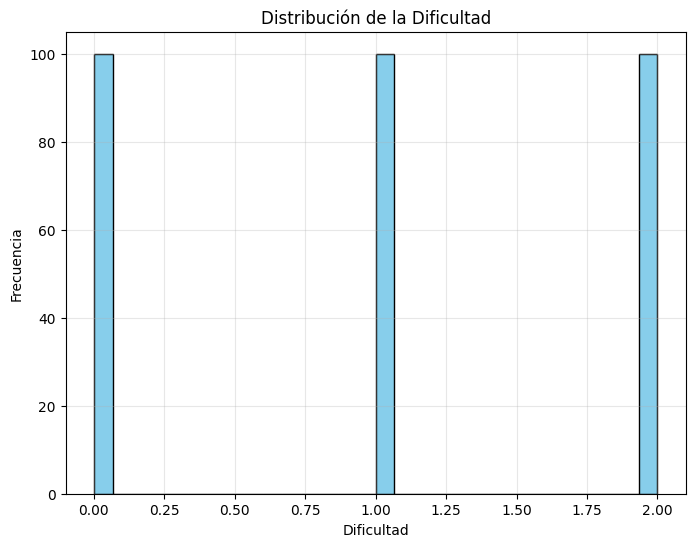

In [9]:
# Distribucion de la dificultad

# Cargar el dataset
df = pd.read_csv("dataset.csv")

# Histograma de la variable 'dificultad'
plt.figure(figsize=(8, 6))
plt.hist(df['dificultad'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de la Dificultad")
plt.xlabel("Dificultad")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

<Figure size 1000x800 with 0 Axes>

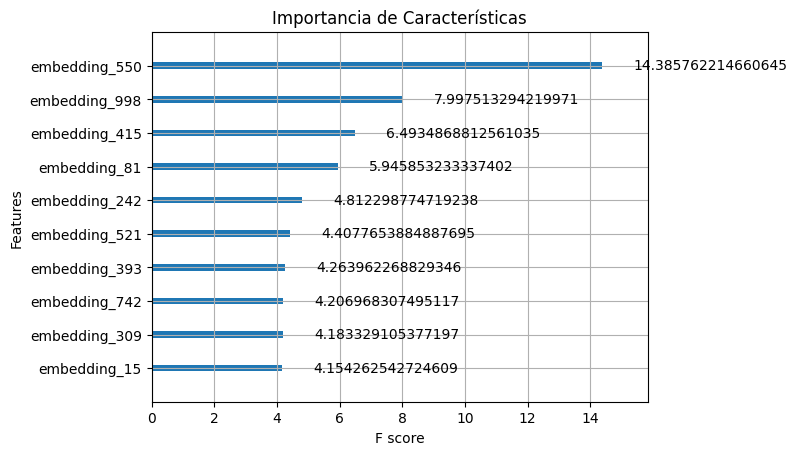

In [10]:
# Importancia de caracteristicas del modelo

# Cargar el modelo entrenado
model = joblib.load("prompt_analysis.joblib")

# Graficar la importancia de las características (usando 'gain' como métrica)
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=10, title="Importancia de Características")
plt.show()

## 6. Probar Modelo

Cargar el modelo, obtener el embedding de una entrada y predecir la dificultad


In [11]:
# Suprimir warnings de Transformers para una salida más limpia
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

# Cargar el modelo XGBoost
model_xgb = joblib.load('prompt_analysis.joblib')

# Inicializar el modelo de embedding
embedding_model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=False)

while True:
    input_text = input("Ingrese su pregunta (o 'PARAR' para salir): ").strip()
    if input_text.upper() == "PARAR":
        break

    # Obtener el embedding del input utilizando BGEM3FlagModel
    embedding_input = embedding_model.encode(
        [input_text],
        batch_size=1,
        max_length=512
    )['dense_vecs']  # Se espera que retorne un array de forma (1, 1024)

    # Realizar la predicción de la dificultad utilizando únicamente el embedding
    prediccion = model_xgb.predict(embedding_input)
    print("La dificultad predicha es:", prediccion[0])

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Ingrese su pregunta (o 'PARAR' para salir): en que consiste este tfm midas
La dificultad predicha es: 0
Ingrese su pregunta (o 'PARAR' para salir): que modelos llm se usan en midas touch
La dificultad predicha es: 0
Ingrese su pregunta (o 'PARAR' para salir): cual es la logica de la comunicacion entre agentes en midas touch
La dificultad predicha es: 1
Ingrese su pregunta (o 'PARAR' para salir): seria posible añadir una nueva fuente de docs a midas architech?
La dificultad predicha es: 0
Ingrese su pregunta (o 'PARAR' para salir): necesito gafas nuevas
La dificultad predicha es: 2
Ingrese su pregunta (o 'PARAR' para salir): como han hecho todo esto tan rapido?
La dificultad predicha es: 2
Ingrese su pregunta (o 'PARAR' para salir): dame una receta de lasaña midas
La dificultad predicha es: 0


KeyboardInterrupt: Interrupted by user

CONCLUSIÓN:

Parece ir bien, aunque no tanto como me esperaba. Si bien un ~82% de accuracy en general podria considerarse como "bueno", lo cierto es que parece decantarse por "pregunta facil". Se confunde entre pregunta facil y dificil.

Además que incluir la palabra "midas" parece influir en el resultado, dado que contesta como pregunta facil a "dame una receta de lasaña midas"

Probaré a hacer finetuning a un BERT entrenado en español, a ver si da mejor resultado que este. Lo haré en otro cuaderno y compararé resultados.